In [0]:
# https://www.tensorflow.org/tutorials/text/word_embeddings
#Representing text as numbers
# Machine learning models take vectors (arrays of numbers) as input. When working with text, 
#the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. 
# In this section, we will look at three strategies for doing so.

In [0]:
# 1. One-hot encodings
# As a first idea, we might "one-hot" encode each word in our vocabulary. 
# Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the).
#  To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. 
# This approach is shown in the following diagram.

In [0]:
# 2. Encode each word with a unique number
# A second approach we might try is to encode each word using a unique number. 
# Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on.
#  We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. 
# This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

In [0]:
#There are two downsides to this approach, however:

  # 1. The integer-encoding is arbitrary (it does not capture any relationship between words).
  # 2. An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, 
       # learns a single weight for each feature. Because there is no relationship between the similarity of any two words 
       # and the similarity of their encodings, this feature-weight combination is not meaningful.

In [0]:
# Word embeddings

In [0]:
# Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding.
#  Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify).
# Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer).
# It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets.
#  A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [1]:
!pip install -q tf-nightly
import tensorflow as tf

     |████████████████████████████████| 519.0MB 29kB/s 
     |████████████████████████████████| 460kB 43.8MB/s 
     |████████████████████████████████| 3.0MB 32.8MB/s 


In [0]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
# Using the Embedding layer

In [0]:
embedding_layer = layers.Embedding(1000, 5)

In [8]:
print(embedding_layer)

In [13]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.01258928, -0.03565614,  0.0080191 ,  0.04794637, -0.02916858],
       [ 0.01570523, -0.01455747,  0.03054276,  0.01457543, -0.04675625],
       [ 0.00080102, -0.03995383,  0.00892412,  0.00073377, -0.02494654]],
      dtype=float32)

In [0]:
# For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

# The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

In [12]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [0]:
# When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality).
# To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. 
# You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest.
#  The Text Classification with an RNN tutorial is a good next step.

In [0]:
# Learning embeddings from scratch
# In this tutorial you will train a sentiment classifier on IMDB movie reviews.
#  In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

In [0]:
# Load the imdb data

In [14]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAGDOF0/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAGDOF0/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteAGDOF0/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
# The "_" in the vocabulary represent spaces. 
# Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:

In [31]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [0]:
# Movie reviews can be different lengths. We will use the padded_batch method to standardize the lengths of the reviews.

In [0]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

In [0]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [0]:
# As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).
# Note the trailing zeros, because the batch is padded to the longest example.

In [62]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 691,    2,  131, ...,    0,    0,    0],
       [  12,  580,    1, ...,    0,    0,    0],
       [  12,   56,  284, ...,    0,    0,    0],
       ...,
       [3294, 1661, 4545, ...,    0,    0,    0],
       [7963, 8002, 2120, ...,    0,    0,    0],
       [ 131,  574,   94, ...,    0,    0,    0]])

In [63]:
print(train_batch.shape)

(10, 700)


In [42]:
print(len(train_labels))

10


In [0]:
# Create a simple model

# 1. Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index.
     #These vectors are learned as the model trains.
     # The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
# 2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible
# 3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
# 4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [0]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

In [53]:
print("Vocabular Size: No.of.reviews", encoder.vocab_size)

Vocabular Size: No.of.reviews 8185


In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile and train the model

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.5197 - accuracy: 0.6821 - val_loss: 0.3618 - val_accuracy: 0.8700
Epoch 2/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2888 - accuracy: 0.8815 - val_loss: 0.3923 - val_accuracy: 0.8200
Epoch 3/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2350 - accuracy: 0.9084 - val_loss: 0.4845 - val_accuracy: 0.8450
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2027 - accuracy: 0.9216 - val_loss: 0.3648 - val_accuracy: 0.8700
Epoch 5/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1806 - accuracy: 0.9314 - val_loss: 0.4179 - val_accuracy: 0.8500
Epoch 6/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1621 - accuracy: 0.9410 - val_loss: 0.2928 - val_accuracy: 0.8850
Epoch 7/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1464 - accuracy: 0.9454 - val_loss: 0.4187 - val_ac

In [0]:
# With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

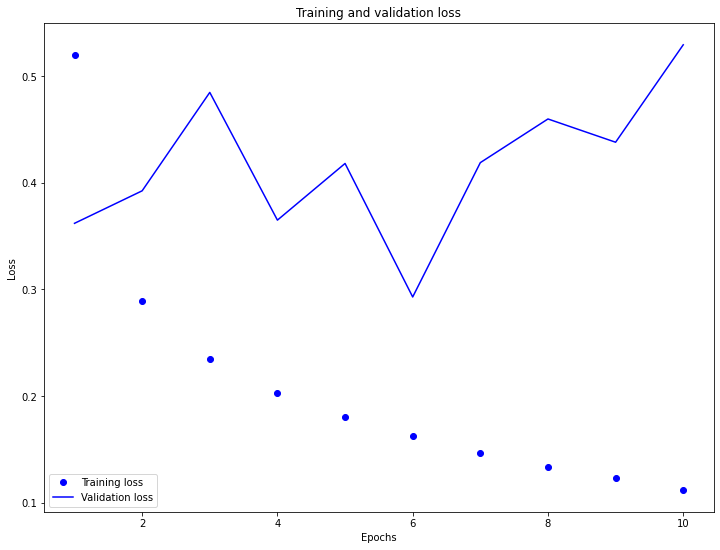

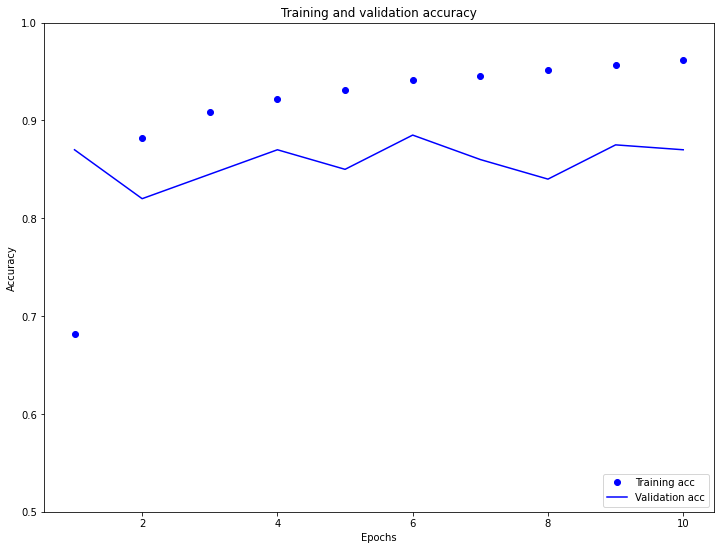

In [47]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
# Retrieve the learned embeddings

In [0]:
# Next, let's retrieve the word embeddings learned during training.
# This will be a matrix of shape (vocab_size, embedding-dimension).

In [64]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [0]:
# We will now write the weights to disk.
# o use the Embedding Projector, we will upload two files in tab separated format: 
# a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [0]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
# If you are running this tutorial in Colaboratory, you can use the following snippet to download these files to your local machine (or use the file browser, View -> Table of contents -> File browser).

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')